In [73]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "mesoscopic-functional-connectivity"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from codes.lib.metrics import graph_lib
from codes.lib.fc.corr_lib import corr, crossCorr
from codes.lib.data_io.qt_wrapper import gui_fnames, gui_fpath
from codes.lib.data_io.yaro.data_fc_db import DataFCDatabase
import codes.lib.plots.connectomics as connectomics
import codes.lib.plots.connectomics_db as connectomics_db
import codes.lib.plots.data_plots as data_plots
from codes.lib.stat.stat_shared import pval_H0_shared_random

%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading Data
* Automatically find subfolders for FC, data and behaviour
* Parse filenames and folders to identify mice, dates and analysis types
* Read all datasets into memory (so far works)

**TODO**:
* Integrate connectomics analysis with pandas

In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
params['root_path_data']  = gui_fpath("Path to data collection",  './')
#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for TE files
Total user files in dataset raw_delay_3_window_4 is 774
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [8]:
#display(dataDB.summary)
#display(dataDB.summaryTE)

In [4]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

IntProgress(value=0, description='Reading TE files', max=774)

IntProgress(value=0, description='Read Neuro Data:', max=220)

Calculated performance 0.7264150943396226 does not match external 0.7333333333333333
Calculated performance 0.803680981595092 does not match external 0.808641975308642
Calculated performance 0.8411764705882353 does not match external 0.8436578171091446
Calculated performance 0.956989247311828 does not match external 0.9621621621621622
Calculated performance 0.6808510638297872 does not match external 0.6956521739130435
Calculated performance 0.9582366589327146 does not match external 0.9604651162790697
Calculated performance 0.4851258581235698 does not match external 0.4840182648401826
--Warning: For iMISS behaviour max index 437 exceeds nTrials 437
---Cropped excessive behaviour trials from 86 to 85
Calculated performance 0.42795389048991356 does not match external 0.6902017291066282
Calculated performance 0.2534562211981567 does not match external 0.30386740331491713
Calculated performance 0.4444444444444444 does not match external 0.47227191413237923
Calculated performance 0.56680161

--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /mnt/hifo_scratch1/Yaro/data_for_TE/neuronal/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found 

In [5]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

# Analysis

## Performance

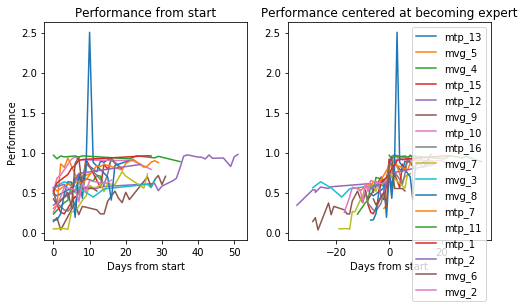

In [6]:
data_plots.plot_performance_by_days(dataDB)

# Basic TE info

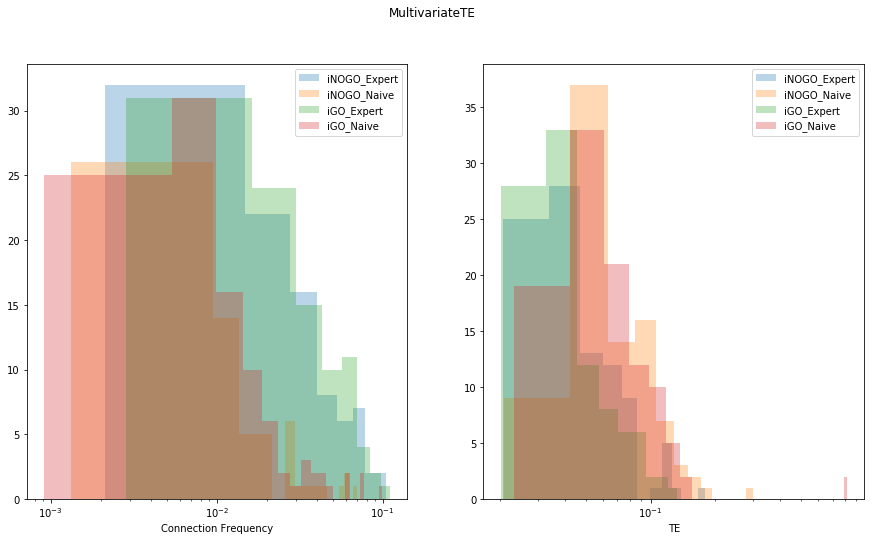

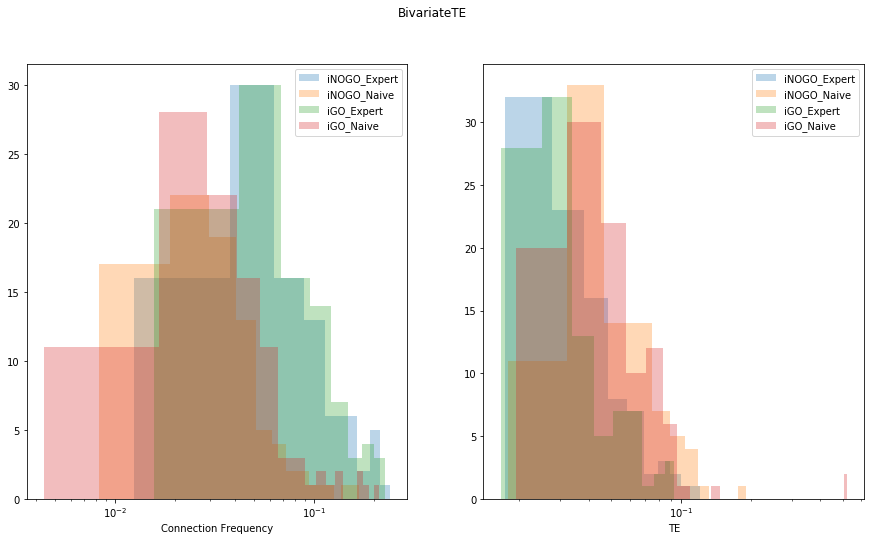

In [10]:
connectomics_db.plot_te_distribution_avgbyperformance(dataDB, 0.01)

### Shared links

1. For each mouse, sort sessions by day
2. For each session, get links as any(isconn(range(3-3.5 sec)))
3. For nearby sessions of same mouse, calc shared_true, and shared_emp_distr

Intermediate Plots:
    * shared_true vs performance for union of all mice
    * 3D plot std(shared_emp_distr) as func of (nConnPre, nConnPost)
    
4. Sweep performance with window. There will be several points in each window
5. Define log-likelihood $L = -2 \log \prod_i P[s_i | H_0]$ where $P$ is the empirical distribution
6. Compute true log_likelihood $L_{true}$
7. Resample empirical distributions of points in the window to construct a set of random log-likelihoods
8. Find P-value as $p = P[L_{true} > L_{rand}]$

In [70]:
FPS = 20 
RANGE_SEC = (3, 3.5)  # Processing time
RANGE_STEP = (int(FPS*RANGE_SEC[0]), int(FPS*RANGE_SEC[1]))

sharedConnDict = {}

for method in dataDB.summaryTE['method'].keys():

    sharedConnDict[method] = {
        'nConnTot'     : [],
        'nConnPre'     : [],
        'nConnPost'    : [],
        'nConnShared'  : [],
        'perf'         : []
    }


    for mousename in dataDB.mice:
        mouseRows = dataDB.get_rows('TE', {'mousename' : mousename})

        isConnAnyRngLst = []
        nConnAnyRng = []
        perfSharedThis = []

        for idx, row in mouseRows.iterrows():
            mousekey = row['mousekey']
            methodThis   = row['method']
            
            if methodThis == method:
                # Find corresponding data file, extract performance
                dataRowsFiltered = dataDB.get_rows('neuro', {'mousekey' : mousekey})
                nRows = dataRowsFiltered.shape[0]
                if nRows != 1:
                    print("Warning: have", len(dataRowsFiltered), "original matches for TE data", mousekey)
                    raise ValueError("Unexpected")
                    
                thisMouseDataIdxs = dataRowsFiltered.index
                perf = dataDB.dataPerformance[thisMouseDataIdxs]
                perfSharedThis += [perf]

                # Compute mean TE and connection frequency
                te, lag, p = dataDB.dataTEFC[idx]
                pRng = p[..., RANGE_STEP[0] : RANGE_STEP[1]]

                nChannel = p.shape[1]
                isConnRng = graph_lib.is_conn(pRng, pTHR)
                isConnAnyRngLst += [np.any(isConnRng, axis=2)]
                nConnAnyRng += [np.sum(isConnAnyRngLst[-1])]

        for i in range(1, len(isConnAnyRngLst)):
            sharedConnDict[method]['nConnTot']    += [nChannel*(nChannel-1)]
            sharedConnDict[method]['nConnPre']    += [nConnAnyRng[i-1]]
            sharedConnDict[method]['nConnPost']   += [nConnAnyRng[i]]
            sharedConnDict[method]['nConnShared'] += [np.sum(nConnAnyRng[i-1] & nConnAnyRng[i])]
            sharedConnDict[method]['perf']        += [perfSharedThis[i]]

In [74]:
tmpDict = sharedConnDict['BivariateTE']

pval_H0_shared_random(
    tmpDict['nConnPre'],
    tmpDict['nConnPost'],
    tmpDict['nConnTot'],
    tmpDict['nConnShared'],
    nResample=2000
)

# freqConnPostNorm = np.array(tmpDict['nConnPost']) / np.array(tmpDict['nConnTot'])
# freqConnSharedNorm = np.array(tmpDict['nConnShared']) / np.array(tmpDict['nConnPost'])

# plt.figure()
# plt.plot(tmpDict['perf'], freqConnPostNorm, '.')
# plt.show()

# plt.figure()
# plt.plot(tmpDict['perf'], freqConnSharedNorm, '.')
# plt.show()

converged after 884 steps
converged after 904 steps
converged after 906 steps
converged after 902 steps
converged after 880 steps
converged after 901 steps
converged after 907 steps
converged after 904 steps
converged after 901 steps
converged after 886 steps
converged after 885 steps
converged after 879 steps
converged after 905 steps
converged after 860 steps
converged after 873 steps
converged after 902 steps
converged after 875 steps
converged after 882 steps
converged after 870 steps
converged after 821 steps
converged after 839 steps
converged after 860 steps
converged after 893 steps
converged after 889 steps
converged after 870 steps
converged after 891 steps
converged after 962 steps
converged after 970 steps
converged after 973 steps
converged after 960 steps
converged after 962 steps
converged after 972 steps
converged after 956 steps
converged after 972 steps
converged after 990 steps
converged after 977 steps
converged after 957 steps
converged after 978 steps
converged af

converged after 974 steps
converged after 970 steps
converged after 977 steps
converged after 986 steps
converged after 968 steps
converged after 973 steps
converged after 976 steps
converged after 974 steps
converged after 977 steps
converged after 972 steps
converged after 980 steps
converged after 890 steps
converged after 886 steps
converged after 901 steps
converged after 889 steps
converged after 899 steps
converged after 897 steps
converged after 897 steps
converged after 911 steps
converged after 898 steps
converged after 892 steps
converged after 891 steps
converged after 881 steps
converged after 891 steps
converged after 905 steps
converged after 890 steps
converged after 895 steps
converged after 889 steps
converged after 898 steps
converged after 911 steps
converged after 885 steps
converged after 893 steps
converged after 902 steps
converged after 890 steps
converged after 889 steps
converged after 888 steps
converged after 893 steps
converged after 895 steps
converged af

TypeError: zip argument #2 must support iteration

## 1. Correlation and Synchrony

**THINGS TO TRY**:
1. MI instead of TE
2. Some clustering measure
3. Repeat for other mice

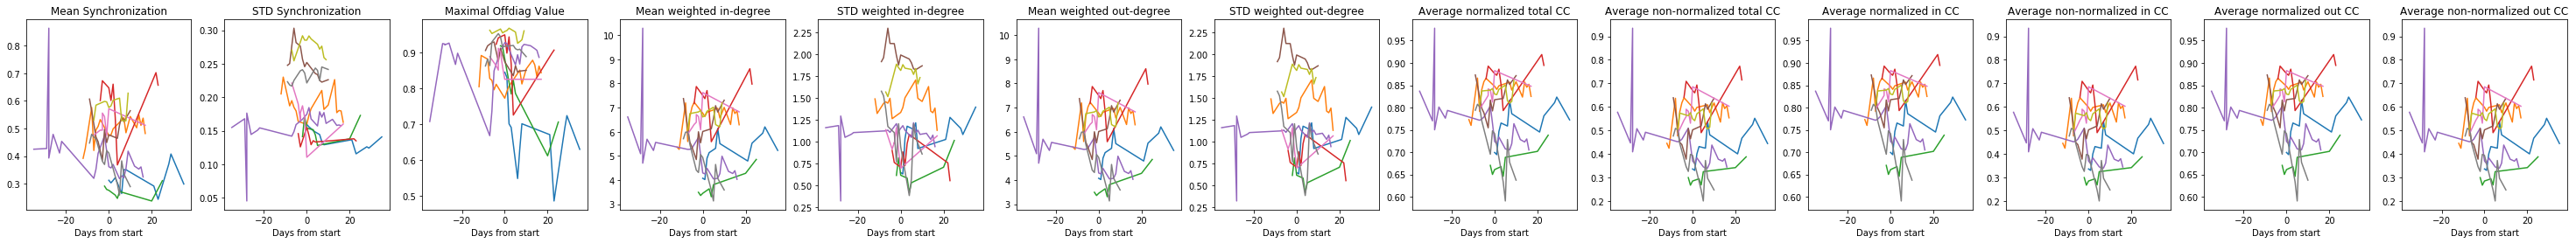

In [9]:
testNames = [
    "Mean Synchronization",
    "STD Synchronization",
    "Maximal Offdiag Value",
    "Mean weighted in-degree",
    "STD weighted in-degree",
    "Mean weighted out-degree",
    "STD weighted out-degree",
    "Average normalized total CC",
    "Average non-normalized total CC",
    "Average normalized in CC",
    "Average non-normalized in CC",
    "Average normalized out CC",
    "Average non-normalized out CC"]
nTest = len(testNames)

fig, ax = plt.subplots(ncols=nTest, figsize=(nTest*4, 4))

for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:    
        dataIdxs = list(mouseData["date"].index)
        
        testResults = np.zeros((len(dataIdxs), nTest))
        for i, dataIdx in enumerate(dataIdxs):
            # Compute cross-correlation absolute value
            dataThis = dataNeuronal[dataIdx].transpose(2,1,0) #channel x time x trial for cross-corr
            cAbs = np.abs(crossCorr(dataThis, 0, 0)[0])
            
            # Compute connectivity metrics
            testResults[i] = np.array([
                *graph_lib.diagonal_dominance(cAbs),
                np.max(graph_lib.offdiag(cAbs)),
                np.mean(graph_lib.degree_in(cAbs)),
                np.std(graph_lib.degree_in(cAbs)),
                np.mean(graph_lib.degree_out(cAbs)),
                np.std(graph_lib.degree_out(cAbs)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=False))
            ])
            
        for iTest in range(nTest):
            ax[iTest].plot(deltaDaysCentered[dataIdxs], testResults[:,iTest], label=mousename)

for iTest in range(nTest):
    ax[iTest].set_title(testNames[iTest])
    ax[iTest].set_xlabel("Days from start")
    #ax[iTest].legend()
plt.show()

## 1.2 Clustering of data

1. For each mouse, for each time, compute corr
2. Compute CC vs time (mean/var)
3. Plot for all mice
4. Then split Go/NoGO

mtp_13
-- mtp_13_2017_03_08_a iGO 116
-- mtp_13_2017_03_09_a iGO 248
-- mtp_13_2017_03_13_a iGO 79
-- mtp_13_2017_03_14_a iGO 332
-- mtp_13_2017_03_15_a iGO 261
-- mtp_13_2017_03_16_a iGO 294
-- mtp_13_2017_03_17_a iGO 404
-- mtp_13_2017_03_20_a iGO 76
-- mtp_13_2017_03_21_a iGO 282
-- mtp_13_2017_03_22_a iGO 280
-- mtp_13_2017_03_23_a iGO 347
-- mtp_13_2017_03_24_a iGO 279
-- mtp_13_2017_03_08_a iNOGO 96
-- mtp_13_2017_03_09_a iNOGO 183
-- mtp_13_2017_03_13_a iNOGO 59
-- mtp_13_2017_03_14_a iNOGO 229
-- mtp_13_2017_03_15_a iNOGO 145
-- mtp_13_2017_03_16_a iNOGO 185
-- mtp_13_2017_03_17_a iNOGO 343
-- mtp_13_2017_03_20_a iNOGO 99
-- mtp_13_2017_03_21_a iNOGO 303
-- mtp_13_2017_03_22_a iNOGO 238
-- mtp_13_2017_03_23_a iNOGO 348
-- mtp_13_2017_03_24_a iNOGO 251


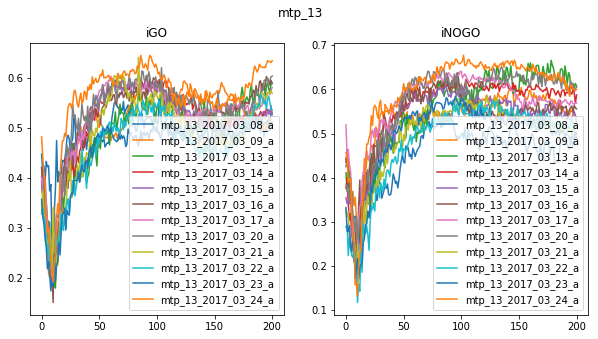

In [41]:
trialKeys = ['iGO', 'iNOGO']
nTrialKeys = len(trialKeys)


for mousename in mice[:1]:
    print(mousename)
    
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
        dataIdxs = list(mouseData["date"].index)
        
        fig, ax = plt.subplots(ncols=nTrialKeys, figsize=(5*nTrialKeys,5))
        fig.suptitle(mousename)
        
        for iKey, trialKey in enumerate(trialKeys):
            for i, dataIdx in enumerate(dataIdxs):
                
                
                dataLabel = pathDataSets['data_path']['mousekey'][dataIdx]
                trialIdx = dataTrials[dataIdx][trialKey]
                dataThis = dataNeuronal[dataIdx][trialIdx-1]

                print("--", dataLabel, trialKey, len(trialIdx))

                nTrial, nTime, nChannel = dataThis.shape

                ccNoNorm = np.zeros(nTime)
                for iTime in range(nTime):
                    corrAbs = np.abs(corr(dataThis[:, iTime, :].T))
                    ccNoNorm[iTime] = np.mean(graph_lib.cl_coeff(corrAbs, normDegree=False))

                ax[iKey].plot(ccNoNorm, label=dataLabel)

            ax[iKey].set_title(trialKey)
            ax[iKey].legend()
plt.show()